# Support Vector Machine
***

In this notebook we will approach the prediction problem using SVMs.

For theory pertaining to SVMs we refer to Andrew Ng's excellent [lecture notes](https://cs229.stanford.edu/main_notes.pdf).

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.model_selection as skm
import sklearn as sk
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Load the data
***
First we load the data, drop all unnecessary columns, and scale the data (see the featureEngineering notebook for details on preliminary preprocessing):

In [242]:
train = pd.read_csv('data/processedTrain.csv')
train.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,2,3,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,0,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,3,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,7,0,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,7,3,2,3,"Allen, Mr. William Henry",0,5,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [243]:
test  = pd.read_csv('data/processedTest.csv')
test.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,7,3,1,2,"Kelly, Mr. James",0,892,3,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,8,3,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,9,3,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,5,3,2,4,"Wirz, Mr. Albert",0,895,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2,3,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [244]:
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

y = train['Survived'].values
X = StandardScaler().fit_transform(train.drop(columns=drop_cols))
X_test  = StandardScaler().fit_transform(test.drop(columns=drop_cols))

We then split the training data into a training and cross-validation subsets (7:3).

In [245]:
X_train, X_cv, y_train, y_cv = skm.train_test_split(X, y, test_size=0.3, random_state=42)

### Linear Kernel
***

We begin by fitting a support vector machine with linear kernel. 

In [246]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=10, kernel='linear')

We perform `K(=5)`-fold cross validation in order to find a suitable regularisation parameter.

In [247]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)

grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.005,0.01,0.1,1,2]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train,y_train)

print('The best parameter is given by: {}'.format(grid.best_params_['C'])) 
print('The scores are:', grid.cv_results_[('mean_test_score')])

The best parameter is given by: 1
The scores are: [0.81540645 0.83468387 0.83307097 0.8556     0.8588     0.8555871 ]


Using `C=1` we check how the model performs on the test data.

In [248]:
best_ = grid.best_estimator_
best_.score(X_cv, y_cv)

0.8395522388059702

We delve deeper into the performance with the aid of a confusion matrix. Definitions are included below for clarity.

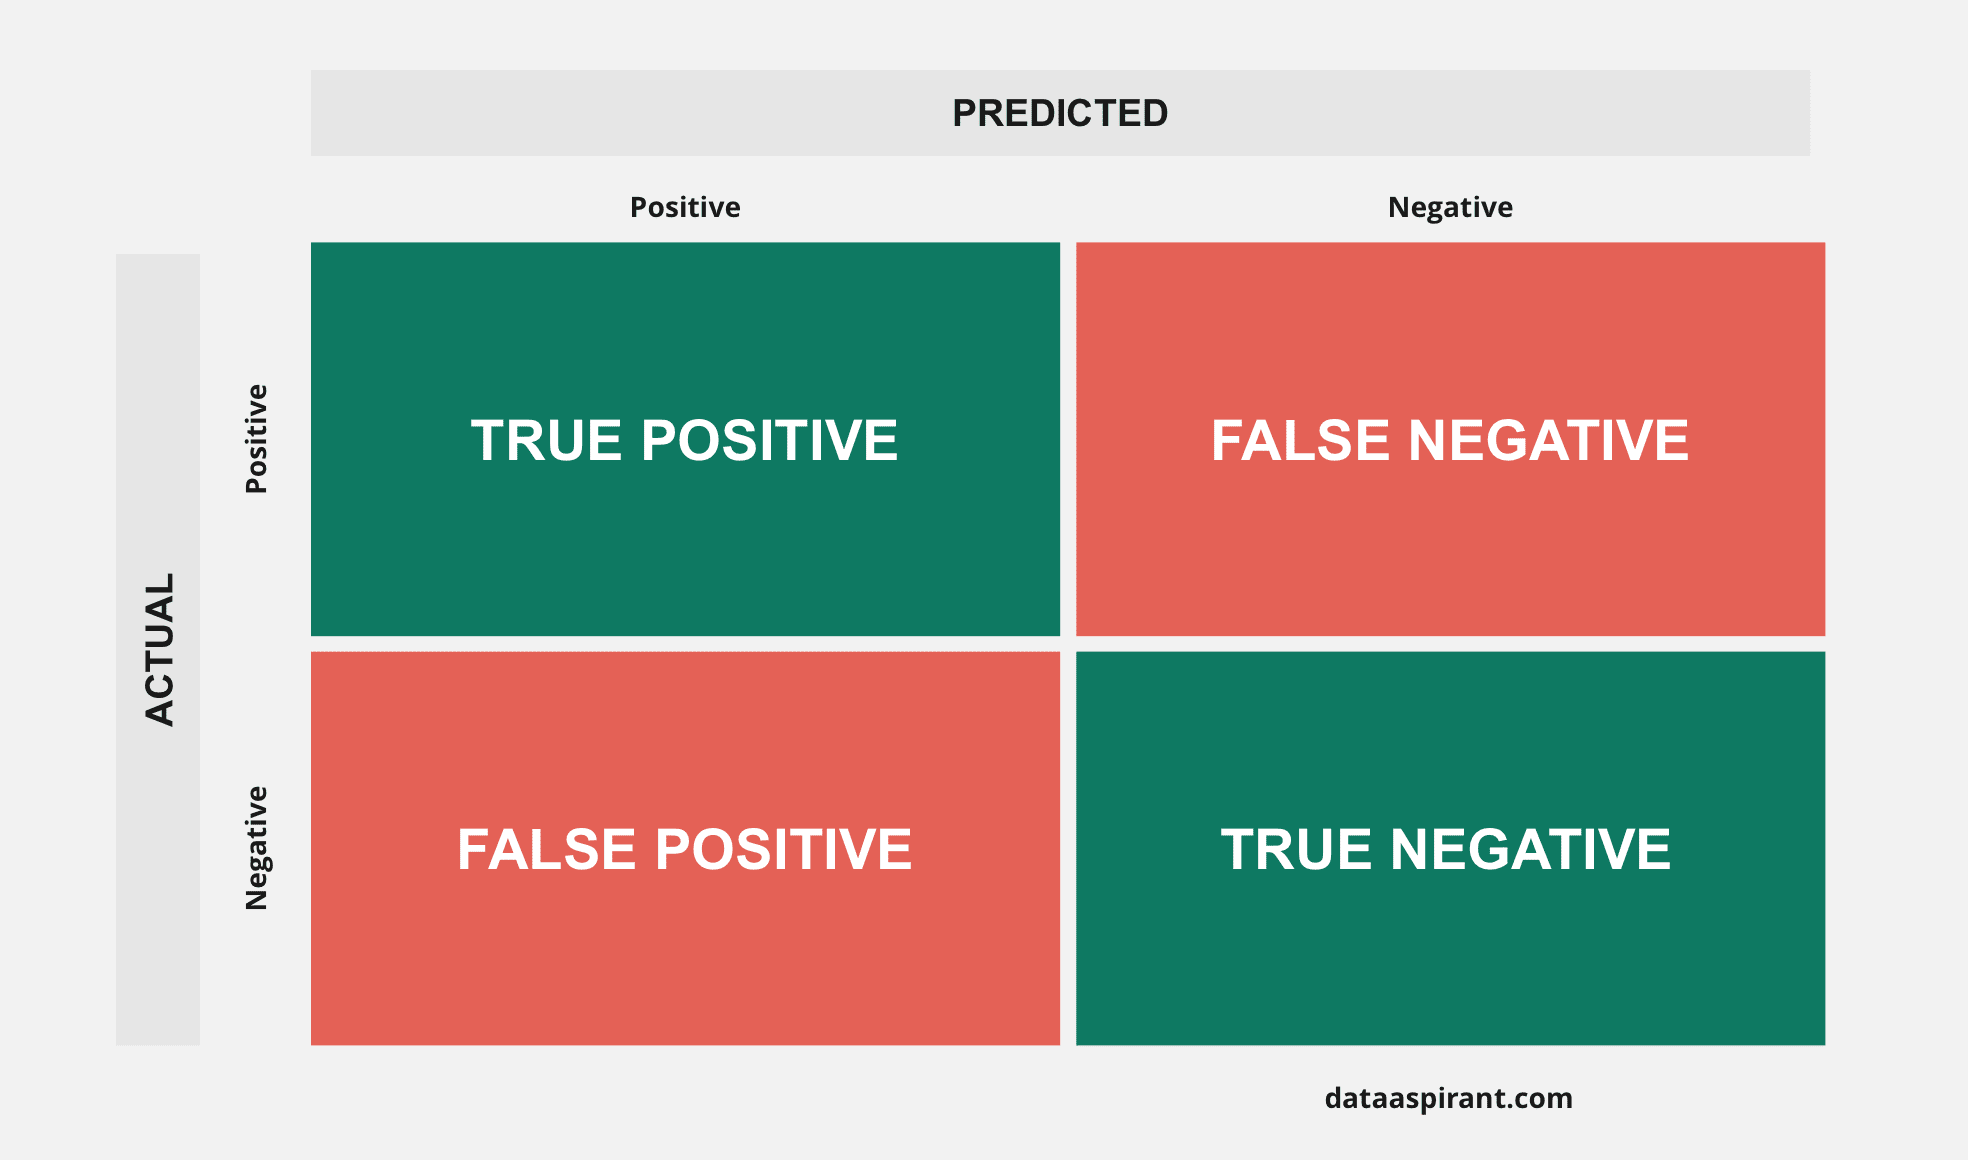

**Definition** 

The True Positive Rate (TPR), False Negative Rate (FPR), True Negative Rate (TNR), and False Negative Rate (FNR) are given by
$$
\begin{gathered}
T P R=\frac{T P}{\text { Actual Positive }}=\frac{T P}{T P+F N} \\
F N R=\frac{F N}{\text { Actual Positive }}=\frac{F N}{T P+F N} \\
T N R=\frac{T N}{\text { Actual Negative }}=\frac{T N}{T N+F P} \\
F P R=\frac{F P}{\text { Actual Negative }}=\frac{F P}{T N+F P}
\end{gathered}
$$


**Definition (Precision)**

Out of all the positive predicted, *Precision* is the percentage that is truly positive. It is the same as *Positive Predictive Rate*.
$$
\text { Precision }=\frac{T P}{T P+F P}
$$


**Definition (Recall)**

Out of the total positive, *Recall* is the percentage that is predicted positive. It is the same as TPR (true positive rate) and *Sensitivity*.
$$
\text { Recall }=\frac{T P}{T P+F N}
$$


**Definition (Specificity)**

Out of the total negative, *Specificity* is the percentage that is predicted negative. It is the same as TNR (true negative rate).
$$
\text { Specificity }=\frac{T N}{T N+F P}
$$


The fraction of correct predictions is 0.84
The precision is 0.82
The recall is 0.78
The specificity is 0.85


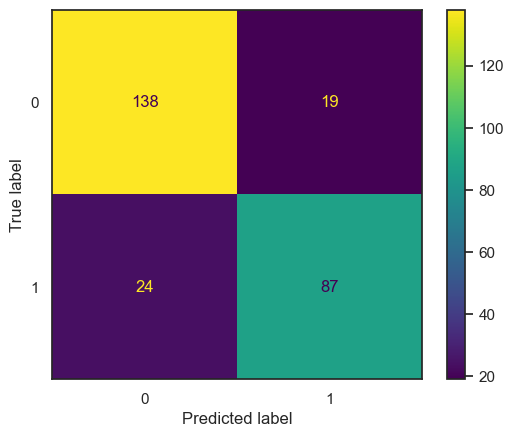

In [249]:
best_ = grid.best_estimator_
y_cv_hat = best_.predict(X_cv)
CM = sk.metrics.confusion_matrix( y_cv, y_cv_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

In [250]:
predictions = best_.predict(X_test).astype(int)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submissions/submissionSVMLinear.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Change of kernel
***
We now do the same as before, but try different kernels to see if we can improve our accuracy.

We use GridSearchCV to test

- regularisation parameter $C$ ranging from 0.1 to 10; and 
- precision parameter $\gamma$ values that range from 0.1 to 10;

with linear, rbf and sigmoid kernels.

In [251]:
model = SVC(probability=True, random_state=0)

# We try (5*5*3=)75 parameter combinations
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': [0.01,0.1, 0.5, 1, 5, 10],
    'kernel': ['rbf', 'sigmoid','linear']
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=5,verbose=1)
grid_search.fit(X_train, y_train) 

best_model = grid_search.best_estimator_ 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [252]:
grid_search.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

The following shows that we perform worse on the test data!

The fraction of correct predictions is 0.84
The precision is 0.85
The recall is 0.74
The specificity is 0.83


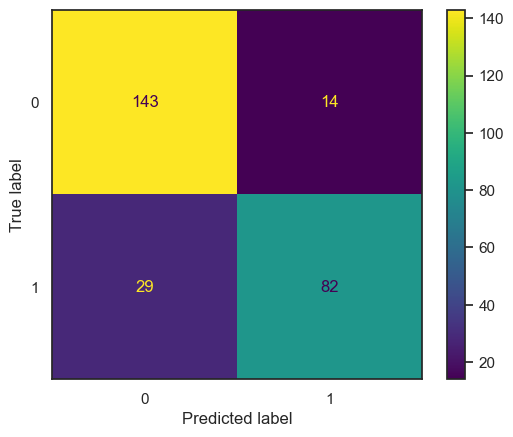

In [253]:
best_ = grid_search.best_estimator_
y_cv_hat = best_.predict(X_cv)
CM = sk.metrics.confusion_matrix( y_cv, y_cv_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

Our precision is up, but both our recall and specificity are down! Let's try and narrow our search to see if we get a higher performance.

In [254]:
from sklearn.feature_selection import SequentialFeatureSelector

model = SVC(kernel='rbf',probability=True, random_state=0)

param_grid = {
    'C': [0.1,0.5,1,2,3,4,5,6,7],
    'gamma': [0.0015,0.01,0.15,0.1,0.05,0.5,1,2]
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train) 

best_model = grid_search.best_estimator_ 
grid_search.best_params_

{'C': 7, 'gamma': 0.01}

We check the confusion matrix...

The fraction of correct predictions is 0.85
The precision is 0.86
The recall is 0.76
The specificity is 0.84


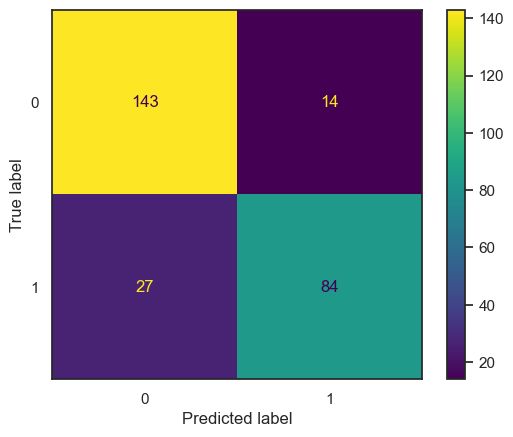

In [255]:
best_ = grid_search.best_estimator_
y_cv_hat = best_.predict(X_cv)
CM = sk.metrics.confusion_matrix( y_cv, y_cv_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

Compared to the linear model our precision is up, but both our recall and specificity are still down. However, our overall accuracy is $2\%$ higher.

In [257]:
model = SVC(kernel='rbf', C=7, gamma=0.01, probability=True, random_state=0)
model.fit(X,y)

SVC(C=7, gamma=0.01, probability=True, random_state=0)

In [258]:
predictions = model.predict(X_test).astype(int)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submissions/submissionSVMrbf.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Feature Selection
***

In a final attempt to improve accuracy, we will try and reduce the number of features. In particular, we try forward selection.

In [232]:
from sklearn.feature_selection import SequentialFeatureSelector

C = [.1,1,5,7,10]
gamma = [0.01,0.1,0.5,1,5]
arr = np.zeros(26)

for x in C:
    for y in gamma:
        svm = SVC(C=x, gamma=y, kernel='rbf')
        # select the best 8 features for the parameters
        sfs = SequentialFeatureSelector(svm, n_features_to_select=12)
        sfs.fit(X_train, y_train)

        # increment the score of the best parameters' indexes
        arr = arr + np.array(list(map(int,sfs.get_support())))
arr = np.array(list(map(int,arr)))

We look at the training data of the top 12 features:

In [233]:
indices = sorted(range(len(arr)), key=lambda i: arr[i])[-12:]
newX_train = X_train[:,indices]
newX_train.shape

(623, 12)

We try and find good parameters for the chosen features:

In [234]:
model = SVC(kernel='rbf',probability=True, random_state=0)

param_grid = {
    'C': [0.1,1,2,3,4,5,6],
    'gamma': [0.01,0.05,0.1,0.15,0.2,0.5,1,2]
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(newX_train, y_train) 

best_model = grid_search.best_estimator_ 
grid_search.best_params_

{'C': 6, 'gamma': 1}

Check performance:

The fraction of correct predictions is 0.84
The precision is 0.85
The recall is 0.74
The specificity is 0.83


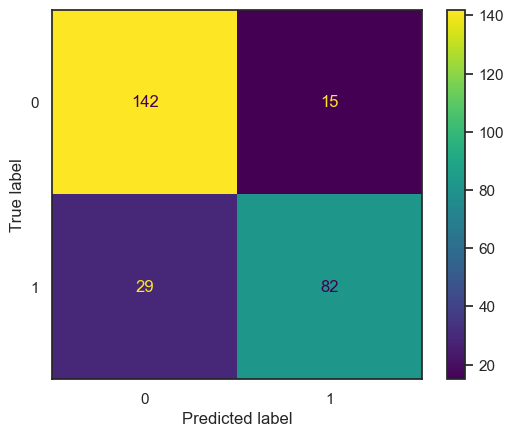

In [235]:
best_ = grid_search.best_estimator_
y_test_hat = best_.predict(X_cv[:,indices])
CM = sk.metrics.confusion_matrix( y_cv, y_test_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

We see no clear improvement.